In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=a9885a62ff4fe31a8cc46b9687376963d46fa0fdcff4f3046e351513d74f09f5
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


**Stage 1: Data preprocessing using spark**





In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, substring,sum,count
from pyspark.sql.types import StringType
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# creating a Spark session
spark = SparkSession.builder.appName("ImportDataset").getOrCreate()


In [ ]:
Raw_Dataset=pd.read_csv("/content/Raw_dataset.csv",encoding = 'unicode_escape', engine ='python')


In [ ]:
#check the null value in dataset
Raw_Dataset.isna().sum()

College_Name      0
Name            948
Content         825
Rating            0
dtype: int64

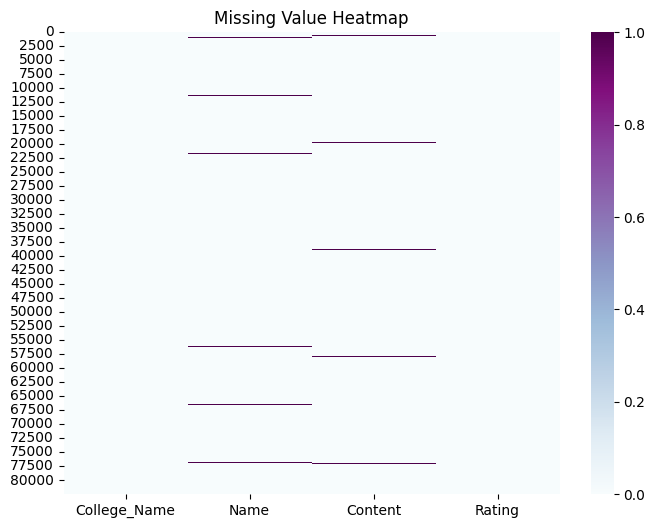

In [ ]:

# Plot missing value heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(Raw_Dataset.isnull(), cmap='BuPu', cbar=True)
plt.title('Missing Value Heatmap')
plt.show()

In [ ]:
#drive.mount('/content/drive')

In [ ]:
# Calculating the percentage of null values
Raw_Dataset.isnull().sum()/len(Raw_Dataset)

College_Name    0.000000
Name            0.011495
Content         0.010004
Rating          0.000000
dtype: float64

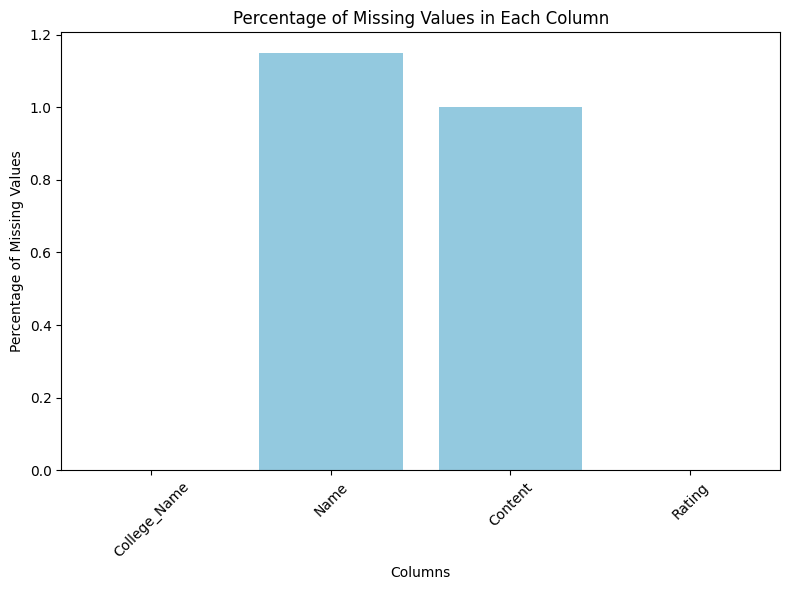

In [ ]:

# Calculating the percentage of missing values in each column
percentages = (Raw_Dataset.isnull().sum() / len(Raw_Dataset)) * 100

# Creating a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=percentages.index, y=percentages.values, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# converting dataframe from pandas to spark
Raw_Dataset= spark.createDataFrame(Raw_Dataset)

In [ ]:
Raw_Dataset.count()

82469

In [ ]:

Raw_Dataset.describe().show()

+-------+--------------------+------------------+--------------------+-------+
|summary|        College_Name|              Name|             Content| Rating|
+-------+--------------------+------------------+--------------------+-------+
|  count|               82469|             82469|               82469|  82469|
|   mean|                null|               NaN|                 NaN|   null|
| stddev|                null|               NaN|                 NaN|   null|
|    min|Aditya Birla Worl...|    #Crazy shorts#|"All the stars ar...|1 Stars|
|    max|mahaveer english ...|áá¶á¶áá¥á·|            ð«¡ â¦|5 Stars|
+-------+--------------------+------------------+--------------------+-------+



In [ ]:
# Droping the column (name)
Raw_Dataset=Raw_Dataset.drop(Raw_Dataset["Name"])

In [ ]:

def fetch_ratings(df):
    """Conveting column type from string to integer
    i.e. Extracting integer value(rating) from string"""

    df = df.withColumn("Ratings", substring(col("Rating"), 1, 1))
    df=df.withColumn("Ratings", col("Ratings").cast("int"))
    df = df.drop("Rating")  # Drop the original "Rating" column

    return df


In [ ]:

Raw_Dataset = fetch_ratings(Raw_Dataset)

In [ ]:
Raw_Dataset.show(10)

+--------------------+--------------------+-------+
|        College_Name|             Content|Ratings|
+--------------------+--------------------+-------+
|Aditya Birla Worl...|                 NaN|      4|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...| Teacher are amazing|      5|
|Aditya Birla Worl...|Undoubtedly one o...|      4|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Studied in this s...|      5|
|Aditya Birla Worl...|Faculty is able t...|      4|
|Aditya Birla Worl...|Faculty is able t...|      5|
+--------------------+--------------------+-------+
only showing top 10 rows



In [ ]:
# Removing the NaN values in 'Content' column
Raw_Dataset = Raw_Dataset.filter(Raw_Dataset["Content"]!="NaN")



In [ ]:
Raw_Dataset.show(10)

+--------------------+--------------------+-------+
|        College_Name|             Content|Ratings|
+--------------------+--------------------+-------+
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...| Teacher are amazing|      5|
|Aditya Birla Worl...|Undoubtedly one o...|      4|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|Studied in this s...|      5|
|Aditya Birla Worl...|Faculty is able t...|      4|
|Aditya Birla Worl...|Faculty is able t...|      5|
|Aditya Birla Worl...|   Need some changes|      3|
+--------------------+--------------------+-------+
only showing top 10 rows



In [ ]:


#drop the content of school which is not useful

Cleaned_Dataset=Raw_Dataset.filter(Raw_Dataset["College_Name"] != "mahaveer english school")

In [ ]:
# Converting spark dataset into pandas
Cleaned_Dataset=Cleaned_Dataset.toPandas()

In [ ]:
#Cleaned_Dataset.to_csv("/content/drive/My Drive/Cleaned_Dataset.csv")

**Stage 2 : Natural Language Processing**

In [ ]:

cluster_keywords = {
     'Faculty': 'teacher teachers faculty faculties staff instructor schoolteacher',
    'Infrastructer': 'Infra environment infrastructre campus lab library laboratory auditorium canteen architecture ',
     'Fees' : 'fees fee schlorship cash online ',
     'Event' : 'event events sport sports ncc gathering extra-curriculum extra-curricular curricular games game' ,
}
cluster_keywords

{'Faculty': 'teacher teachers faculty faculties staff instructor schoolteacher',
 'Infrastructer': 'Infra environment infrastructre campus lab library laboratory auditorium canteen architecture ',
 'Fees': 'fees fee schlorship cash online ',
 'Event': 'event events sport sports ncc gathering extra-curriculum extra-curricular curricular games game'}

In [ ]:
# Creating an object of vectorizer
vectorizer = CountVectorizer()

In [ ]:
# Dividing original dataset into two datasets
df1=Cleaned_Dataset.iloc[:40000,:]
df2=Cleaned_Dataset.iloc[40000:,:]

**Stage 3 : Clustering**




In [ ]:
def cluster_data(df):
  """Clustering the dataframe into different clusters,
   on the basis of similar keywords"""

  df1_vectoriser=vectorizer.fit_transform(df['Content'])
  keyword_vectors=vectorizer.transform(cluster_keywords.values()).toarray()
  kmeans = KMeans(n_clusters=len(cluster_keywords), random_state=42, init=keyword_vectors)
  clusters = kmeans.fit_predict(df1_vectoriser.toarray())
  df["cluster"]=clusters
  df['predicted_cluster_name'] = [list(cluster_keywords.keys())[cluster] for cluster in clusters]
  return df

In [ ]:
#function call
df1_result=cluster_data(df1)
df2_result=cluster_data(df2)

In [ ]:
df1_result.tail(10)

,College_Name,Content,Ratings,cluster,predicted_cluster_name
39990,Dhirubhai Ambani International School,Nice school with good administration. Values y...,5,2,Fees
39991,Dhirubhai Ambani International School,Faculty is able to keep my kid intrested in study,5,0,Faculty
39992,Dhirubhai Ambani International School,"Hi All, is want to provide feedback about SNBP...",1,2,Fees
39993,Dhirubhai Ambani International School,Faculty is able to keep my kid intrested in study,5,0,Faculty
39994,Dhirubhai Ambani International School,I love to be part of SNBP Rahatni family. It's...,5,2,Fees
39995,Dhirubhai Ambani International School,My daughter is studying in The Lexicon Interna...,5,1,Infrastructer
39996,Dhirubhai Ambani International School,My child is in 1st and during this pandemic I ...,5,1,Infrastructer
39997,Dhirubhai Ambani International School,Faculty is able to keep my kid intrested in study,4,0,Faculty
39998,Dhirubhai Ambani International School,Faculty is able to keep my kid intrested in study,5,0,Faculty
39999,Dhirubhai Ambani International School,"11 What is the fee structure of science, who w...",3,2,Fees


In [ ]:

# Combining the dataset
clusterd_dataset=df1_result.append(df2_result)
clusterd_dataset.shape

(81498, 5)

In [ ]:
#clusterd_dataset.to_csv("/content/drive/My Drive/clusterd_dataset.csv")

In [ ]:
clusterd_dataset.head(1900).tail(10)

,College_Name,Content,Ratings,cluster,predicted_cluster_name
1890,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
1891,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
1892,Aditya Birla World Academy,One of the best schools in kharadi. My son is ...,5,1,Infrastructer
1893,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
1894,Aditya Birla World Academy,TKS is the best place to work as the Managemen...,5,1,Infrastructer
1895,Aditya Birla World Academy,"I am quite satisfied with Euro School, Kharadi...",5,1,Infrastructer
1896,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,4,0,Faculty
1897,Aditya Birla World Academy,My son Laksh is studying in The Orbis School K...,5,1,Infrastructer
1898,Aditya Birla World Academy,ð â¦,5,2,Fees
1899,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,3,0,Faculty


In [ ]:
clusterd_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81498 entries, 0 to 81497
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   College_Name            81498 non-null  object
 1   Content                 81498 non-null  object
 2   Ratings                 81498 non-null  int32 
 3   cluster                 81498 non-null  int32 
 4   predicted_cluster_name  81498 non-null  object
dtypes: int32(2), object(3)
memory usage: 2.5+ MB


**Recommender system**

In [ ]:
# take mean of all rating on the basis of category to form the pivot matrix

rating = clusterd_dataset.groupby(["College_Name","predicted_cluster_name"]).agg({"Ratings":"mean"})

In [ ]:
rating.reset_index(inplace=True)

In [ ]:
rating

,College_Name,predicted_cluster_name,Ratings
0,Aditya Birla World Academy,Event,5.000000
1,Aditya Birla World Academy,Faculty,4.659375
2,Aditya Birla World Academy,Fees,4.038190
3,Aditya Birla World Academy,Infrastructer,4.464286
4,Army Public School,Fees,4.079518
...,...,...,...
111,Utpal Shanghvi Global School,Fees,3.986683
112,Utpal Shanghvi Global School,Infrastructer,4.450151
113,Vikhe Patil Memorial School,Event,4.315789
114,Vikhe Patil Memorial School,Fees,4.534161


In [ ]:
# form the pivot matrix for recommendation
matrix=rating.pivot(index='predicted_cluster_name',columns="College_Name",values="Ratings")

In [ ]:
matrix

College_Name,Aditya Birla World Academy,Army Public School,Arya Vidya Mandir Bandra West Mumbai,Ascend International School Mumbai,Bal Shikshan Mandir English Medium School,Bombay Scottish School,"Chatrabhuj Narsee Memorial School, Vile Parle, Mumbai",Childrenâs Academy Kandivali Ashok Nagar Mumbai,"Childrenâs Academy, Malad, Mumbai",D.A.V. Public School,...,Sevasadan English Medium School,Shishuvan School,The Cathedral and John Connon School,The Kalyani School,"The Lexicon International School Wagholi, Pune","The Orbis School, Keshav Nagar, Pune",The Somaiya School Mumbai,Udayachal High School Vikhroli Mumbai,Utpal Shanghvi Global School,Vikhe Patil Memorial School
predicted_cluster_name,,,,,,,,,,,,,,,,,,,,,
Event,5.000000,NaN,5.000000,NaN,NaN,5.000000,NaN,5.000000,5.000000,NaN,...,3.454545,4.434839,4.433612,4.576923,4.779330,4.108108,4.412935,4.405328,4.421245,4.315789
Faculty,4.659375,NaN,4.679214,4.676760,NaN,4.686038,4.672657,4.675481,4.651685,NaN,...,NaN,4.659151,4.671684,NaN,NaN,NaN,4.727723,4.665399,4.684070,NaN
Fees,4.038190,4.079518,4.019372,4.077501,4.488889,4.047798,4.104767,4.028551,4.139742,4.177481,...,4.437500,4.030211,4.026071,4.446927,4.569231,3.652632,4.045685,4.017202,3.986683,4.534161
Infrastructer,4.464286,3.363636,4.505000,4.488595,2.400000,4.500000,4.474664,4.524199,4.500000,3.476923,...,3.000000,4.575342,4.565315,4.840000,4.806916,4.575000,4.647368,4.570526,4.450151,5.000000


In [ ]:
# matrix.fillna(0)


In [ ]:
# Create the matrix with required input
target_school = "Aditya Birla World Academy"
target_school_ratings = matrix[target_school]

In [ ]:
# Calculate correlations between the target school and other schools
correlation = matrix.corrwith(target_school_ratings)


In [ ]:

# Convert similarities to a DataFrame for better readability
correlated_df = pd.DataFrame(correlation, columns=['Correlation'])

In [ ]:

# Sort schools based on similarity in descending order
similar_schools = correlated_df.sort_values(by='Correlation', ascending=False)
threshold=0.5
print(similar_schools[similar_schools["Correlation"]>threshold])

                                                    Correlation
College_Name                                                   
Aditya Birla World Academy                             1.000000
Ascend International School Mumbai                     1.000000
Chatrabhuj Narsee Memorial School, Vile Parle, ...     0.999260
Bombay Scottish School                                 0.999218
Childrenâs Academy, Malad, Mumbai                    0.998330
Arya Vidya Mandir Bandra West Mumbai                   0.998195
Childrenâs Academy Kandivali Ashok Nagar Mumbai      0.997111
The Lexicon International School Wagholi, Pune         0.767663
Utpal Shanghvi Global School                           0.706293
Dhirubhai Ambani International School                  0.697843
Oberoi International School                            0.660341
The Cathedral and John Connon School                   0.654963
Shishuvan School                                       0.652620
Ecole Mondiale World School Mumbai      

In [ ]:

clusterd_dataset

,College_Name,Content,Ratings,cluster,predicted_cluster_name
0,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
1,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
2,Aditya Birla World Academy,Teacher are amazing,5,2,Fees
3,Aditya Birla World Academy,Undoubtedly one of the best CBSE schools locat...,4,1,Infrastructer
4,Aditya Birla World Academy,Faculty is able to keep my kid intrested in study,5,0,Faculty
...,...,...,...,...,...
81493,Vikhe Patil Memorial School,Their is only doing Monoply & Exploitation Of ...,1,2,Fees
81494,Vikhe Patil Memorial School,My daughter is in this school. Best school. Te...,4,3,Event
81495,Vikhe Patil Memorial School,i am extremely happy with the education and te...,5,2,Fees
81496,Vikhe Patil Memorial School,i am extremely happy with the education and te...,5,2,Fees


In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clusterd_dataset.to_csv("/content/drive/My Drive/tableua_data.csv")